# Stochastic depth

[Dropout](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) proved to be working and that often improves the stability of the network. What if you throw out not just the weights from the layer, but the entire layer or even the whole block of layers? 

This question was asked by Gao Huang, Yu Sun, Zhuang Liu and described in an [article](https://arxiv.org/abs/1603.09382) "Deep Networks with Stochastic Depth".

In this notebook, we will check the assumption that stochastic depth helps deep network predicts better than without it. 

Pay attention to the [file](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/research/stochastic_depth/resnet_with_stochastic_depth.py) with the model in which we inherit from the standard ResNet and change it to create stochastic depth ResNet.


In [1]:
import sys

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

sys.path.append('../..')

import utils
from resnet_with_stochastic_depth import StochasticResNet
from dataset import B,V,F
from dataset.opensets import MNIST
from dataset.models.tf import ResNet50

For doing so we will work with MNIST dataset 

In [2]:
dset = MNIST()

Extracting ExtractingExtracting/tmp/train-labels-idx1-ubyte.gz 
/tmp/train-images-idx3-ubyte.gzExtracting /tmp/t10k-images-idx3-ubyte.gz
 
/tmp/t10k-labels-idx1-ubyte.gz


And create config for our models

In [3]:
ResNet_config = {
    'inputs': {'images': {'shape': (28, 28, 1)},
               'labels': {'classes': (10),
                          'transform': 'ohe',
                          'dtype': 'int64',
                          'name': 'targets'}},
    'input_block/inputs': 'images',
    'loss': 'softmax_cross_entropy',
    'optimizer': 'Adam',
    'output': dict(ops=['accuracy'])
}

Stochastic_config = {**ResNet_config}

Now write pipelines to ResNet model

In [4]:
res_train_ppl = (dset.train.p
                 .init_model('dynamic',
                             ResNet50,
                             'resnet',
                             config=ResNet_config)
                 .train_model('resnet',
                              feed_dict={'images': B('images'),
                                         'labels': B('labels')}))
res_test_ppl = (dset.test.p
                .init_variable('resacc', init_on_each_run=list)
                .import_model('resnet', res_train_ppl)
                .predict_model('resnet',
                               fetches='output_accuracy',
                               feed_dict={'images': B('images'),
                                          'labels': B('labels')},
                               save_to=V('resacc'), 
                               mode='a'))

And create pipelines to Stochastic ResNet model

In [5]:
stochastic_train_ppl = (dset.train.p
                        .init_model('dynamic',
                                    StochasticResNet,
                                    'stochastic',
                                    config=Stochastic_config)
                        .init_variable('stochasticacc', init_on_each_run=list)
                        .train_model('stochastic',
                                     feed_dict={'images': B('images'),
                                                'labels': B('labels')}))
stochastic_test_ppl = (dset.test.p
                       .init_variable('stochasticacc', init_on_each_run=list)
                       .import_model('stochastic', stochastic_train_ppl)
                       .predict_model('stochastic',
                                      fetches='output_accuracy',
                                      feed_dict={'images': B('images'),
                                                 'labels': B('labels')},
                                      save_to=V('stochasticacc'),
                                      mode='a'))

Let's train our models

In [6]:
for i in tqn(range(1000)):
    res_train_ppl.next_batch(400, n_epochs=None, shuffle=True)
    res_test_ppl.next_batch(400, n_epochs=None, shuffle=True)
    stochastic_train_ppl.next_batch(400, n_epochs=None, shuffle=True)
    stochastic_test_ppl.next_batch(400, n_epochs=None, shuffle=True)

Widget Javascript not detected.  It may not be installed or enabled properly.


Show test accuracy for all iterations

../../utils.py:44: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../../utils.py:45: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


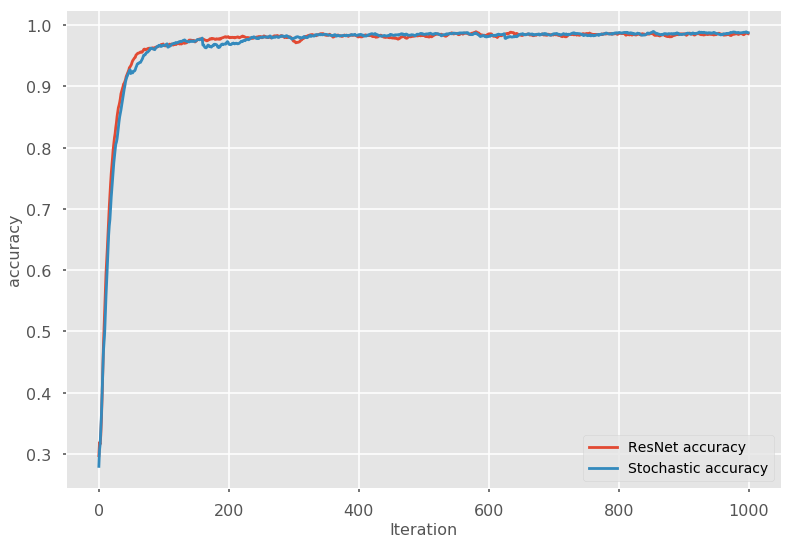

In [7]:
resnet_loss = res_test_ppl.get_variable('resacc')
stochastic_loss = stochastic_test_ppl.get_variable('stochasticacc')
utils.draw(resnet_loss, 'ResNet', stochastic_loss, 'Stochastic', window=20, type_data='accuracy')

It can be seen from the plot that the model with stochastic depth has a big variance, but reaches a similar quality with the usual model

### Conclusion:
* Dropping blocks from the network strongly affects the variance of the output.
* With the passage of time, this dispersion does not decrease.

### And what's next?
* In our experiment, we chose a certain shutdown threshold. You can choose another one to achieve better quality.
* If you still have not completed our tutorial, you can fix it right [now](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/tutorials/I.Dataset/I.Dataset.ipynb)!
* Read and apply another research:
    * [Squeeze and excitation](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/research/squeeze_and_excitation/squeeze_and_excitation.ipynb) block in ResNet
    * Experiments with [weights](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/research/zeroing_of_weights/zeroing_of_weights.ipynb)
    * [FreezeOut](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/research/freezeout/freezeout.ipynb)
    * Network response to [augmentation of data](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/research/augmentation/augmentation.ipynb)
